# Home Credit Default Risk

# STAGE 1 - EDA (Exploratory Data Analysis)

## 0. Prepare

### A) Import Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# ----------------------------------------------------
import sklearn
import scipy
from scipy.stats import shapiro

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn import under_sampling, over_sampling

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# ----------------------------------------------------
from sklearn.metrics import auc, roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

### B) Import Dataset

In [41]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv("application_test.csv")

### C) Define functions

In [42]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    

def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

## 1 Information about data

In [43]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [44]:
train.shape

(307511, 122)

In [45]:
test.shape

(48744, 121)

In [46]:
train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

## 2 Statistical Summary

In [47]:
pd.set_option('display.max_rows', train.shape[0])
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


In [48]:
pd.set_option('display.max_rows', train.shape[0])
train.describe(include=['O']).T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


## 3 Check Missing Value

In [49]:
print(train.isna().sum().sum())

9152465


In [50]:
print(test.isna().sum().sum())

1404419


In [51]:
pd.DataFrame(train.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_MEDI,214865
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
NONLIVINGAPARTMENTS_MEDI,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_MODE,210199
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199


In [52]:
pd.DataFrame(test.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_AVG,33495
COMMONAREA_MODE,33495
COMMONAREA_MEDI,33495
NONLIVINGAPARTMENTS_AVG,33347
NONLIVINGAPARTMENTS_MODE,33347
NONLIVINGAPARTMENTS_MEDI,33347
FONDKAPREMONT_MODE,32797
LIVINGAPARTMENTS_AVG,32780
LIVINGAPARTMENTS_MODE,32780
LIVINGAPARTMENTS_MEDI,32780


## 4 Check Data Duplikat

In [53]:
train.duplicated().sum()

0

In [54]:
test.duplicated().sum()

0

## 5 Insight

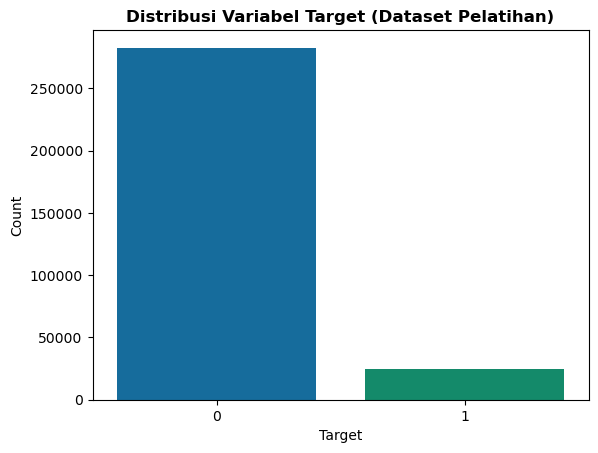

In [55]:
sns.countplot(x='TARGET', data=train)
plt.ylabel('Count')
plt.xlabel('Target')
plt.title('Distribusi Variabel Target (Dataset Pelatihan)',fontweight='bold')
plt.savefig("Distribusi Variabel Target (Dataset Pelatihan).png", transparent=True)
plt.show()

train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'Repaid Loan'*masalah kelas yang tidak seimbang pada Features "TARGET"*

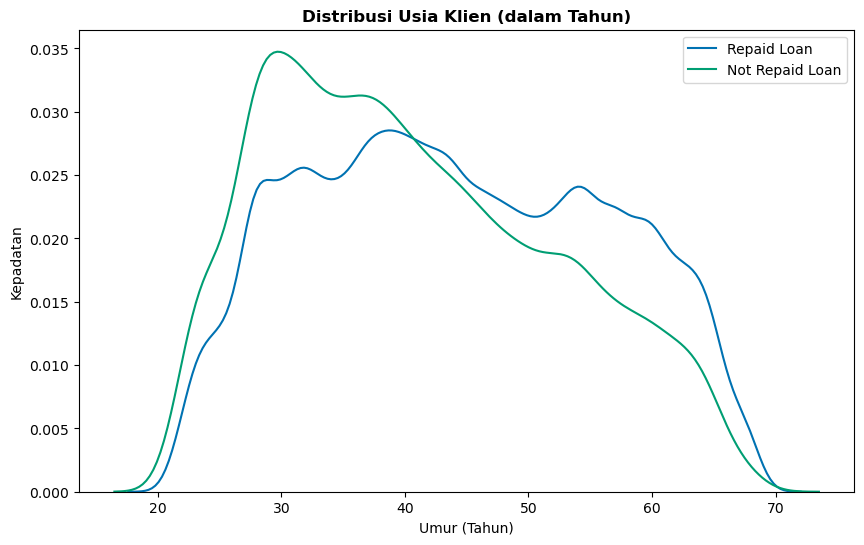

In [56]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'Repaid Loan')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'Not Repaid Loan')
plt.xlabel('Umur (Tahun)')
plt.ylabel('Kepadatan')
plt.legend()
plt.title('Distribusi Usia Klien (dalam Tahun)', fontweight='bold')
plt.show()

*seiring bertambahnya usia klien, tingkat nasabah yang mengalami kesulitan membayar pinjaman yang terus menurun*


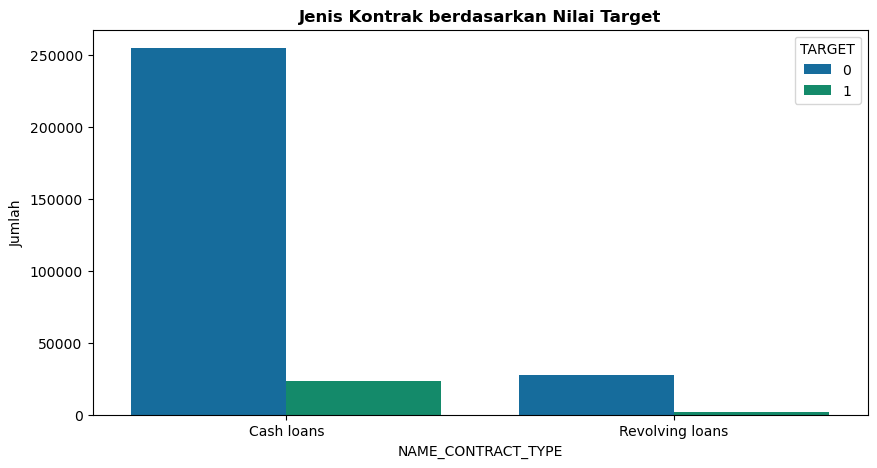

In [57]:
plt.figure(figsize=(10,5))
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=train)
plt.title('Jenis Kontrak berdasarkan Nilai Target', fontweight='bold')
plt.ylabel('Jumlah')
plt.show()

*Rasio pinjaman tidak dilunasi (Target =1) untuk
pinjaman Tunai adalah 8,35%, sedangkan rasio
pinjaman tidak dilunasi (Target =1) untuk
pinjaman Revoling adalah 5,48%.*

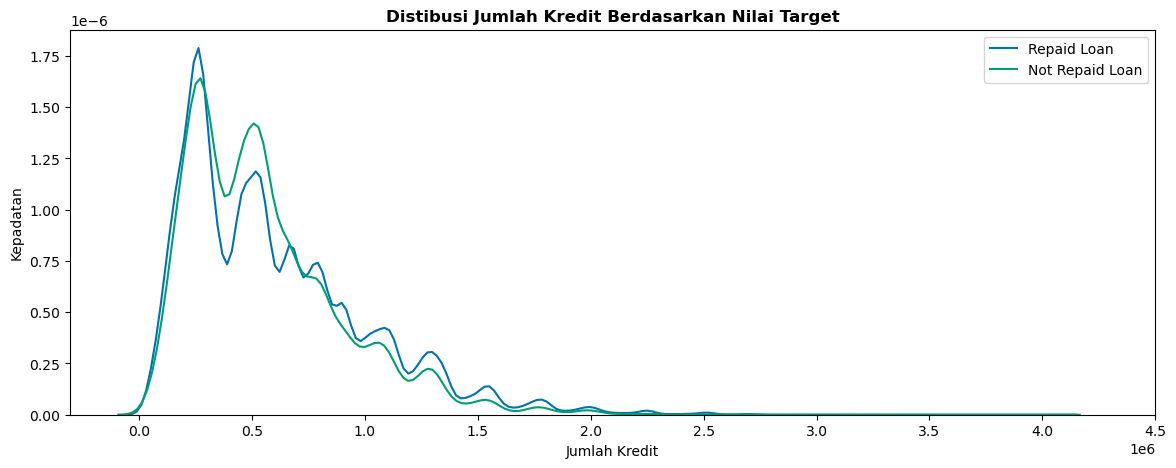

In [58]:
plt.figure(figsize=(14,5))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(train.loc[train['TARGET'] == 0, 'AMT_CREDIT'], 
            label = 'Repaid Loan')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'AMT_CREDIT'], 
            label = 'Not Repaid Loan')
plt.xlabel('Jumlah Kredit')
plt.xticks(np.arange(0, 5000000, 500000))
plt.ylabel('Kepadatan')
plt.legend()
plt.title('Distibusi Jumlah Kredit Berdasarkan Nilai Target', fontweight='bold')
plt.show()

*Distribusi jumlah kredit yang dibayar tepat waktu dan mengalami kesulitan
membayar adalah serupa. Tetapi terdapat anomali pada jumlah kredit
kisaran antara 400.000 hingga 600.000 memiliki rasio pinjaman yang tidak
dilunasi lebih tinggi.*

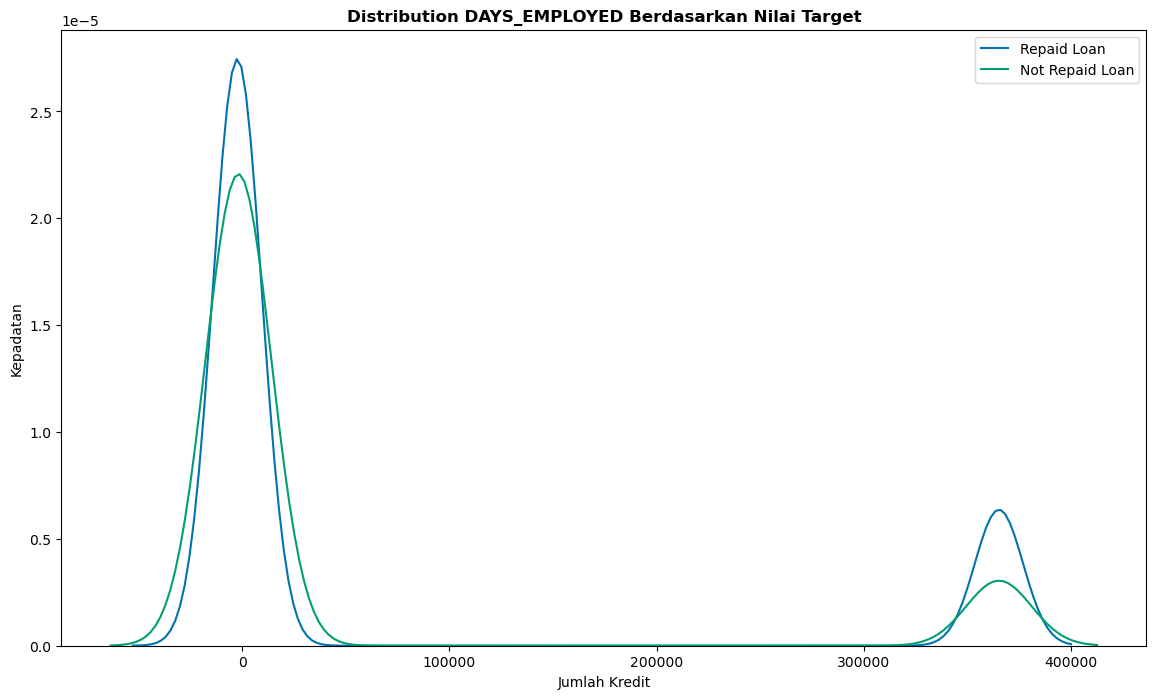

In [59]:
plt.figure(figsize=(14,8))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_EMPLOYED'], 
            label = 'Repaid Loan')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_EMPLOYED'], 
            label = 'Not Repaid Loan')
plt.xlabel('Jumlah Kredit')
plt.ylabel('Kepadatan')
plt.legend()
plt.title('Distribution DAYS_EMPLOYED Berdasarkan Nilai Target', fontweight='bold')
plt.show()

*Distibusi pinjaman mengalami kesulitan membayar memuncak pada
DAYS_EMPLOYED sekitar nol. Nilai yang sama dengan dan di bawah nol cenderung
mengindikasikan bahwa nasabah tersebut menganggur. Sehingga kemampuan
seseorang untuk memperbaiki pinjaman mereka tampaknya berkorelasi positif
dengan masa kerja di pekerjaan mereka saat ini*

# STAGE 2 - Data Pre-processing

## 1. Handle Missing Values

### A) Numerical Field

Menghapus data yang kosong jika memliki jumlah nilai kosong lebih dari 60% bari datanya

In [60]:
threshold_train = len(train) * 0.60
int(threshold_train)

184506

In [61]:
threshold_test = len(test) * 0.60
int(threshold_test)

29246

In [62]:
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')
******************************************
In test data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')


In [63]:
train_new = train.dropna(axis=1, thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test.dropna(axis=1, thresh=threshold_test)
print(test_new.shape)

(307511, 73)
******************************************
(48744, 72)


Mengatasi Numerical Field menggunkan mode

In [64]:
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

#----------------------------------------------------
numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [65]:
numeric_train = train_new[final_numeric_feature]

#-------------------------------------------
numeric_test = test_new[final_numeric_feature_test]

numeric_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
pd.DataFrame(numeric_train.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,60965
AMT_REQ_CREDIT_BUREAU_YEAR,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_HOUR,41519
DEF_60_CNT_SOCIAL_CIRCLE,1021
OBS_60_CNT_SOCIAL_CIRCLE,1021
DEF_30_CNT_SOCIAL_CIRCLE,1021


In [67]:
pd.DataFrame(numeric_test.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,8668
AMT_REQ_CREDIT_BUREAU_YEAR,6049
AMT_REQ_CREDIT_BUREAU_QRT,6049
AMT_REQ_CREDIT_BUREAU_MON,6049
AMT_REQ_CREDIT_BUREAU_WEEK,6049
AMT_REQ_CREDIT_BUREAU_DAY,6049
AMT_REQ_CREDIT_BUREAU_HOUR,6049
DEF_60_CNT_SOCIAL_CIRCLE,29
OBS_60_CNT_SOCIAL_CIRCLE,29
OBS_30_CNT_SOCIAL_CIRCLE,29


Mengambil kolom yang masih memiliki nilai null

In [68]:
numeric_train_is_null = numeric_train.isnull().sum() != 0
final_numeric_train_feature = numeric_train.columns[numeric_train_is_null].tolist()
print("In train: \n",final_numeric_train_feature)

print("****************************************")
numeric_test_is_null_test = numeric_test.isnull().sum() != 0
final_numeric_test_feature = numeric_test.columns[numeric_test_is_null_test].tolist()
print("In test: \n",final_numeric_test_feature)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
****************************************
In test: 
 ['AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


Mengganti nilai null menggunakan median

In [69]:
print("In train:\n")
for i in range(len(final_numeric_train_feature)):
    replace_median(numeric_train, final_numeric_train_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_numeric_test_feature)):
    replace_median(numeric_test, final_numeric_test_feature[i])

In train:

NaN in AMT_ANNUITY raplaced with 24903.0
NaN in AMT_GOODS_PRICE raplaced with 450000.0
NaN in CNT_FAM_MEMBERS raplaced with 2.0
NaN in EXT_SOURCE_2 raplaced with 0.5659614260608526
NaN in EXT_SOURCE_3 raplaced with 0.5352762504724826
NaN in OBS_30_CNT_SOCIAL_CIRCLE raplaced with 0.0
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.0
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 0.0
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.0
NaN in DAYS_LAST_PHONE_CHANGE raplaced with -757.0
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.0
NaN in AMT_REQ_CREDIT_BUREAU_DAY raplaced with 0.0
NaN in AMT_REQ_CREDIT_BUREAU_WEEK raplaced with 0.0
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.0
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.0
NaN in AMT_REQ_CREDIT_BUREAU_YEAR raplaced with 1.0
************************************
In test:

NaN in AMT_ANNUITY raplaced with 26199.0
NaN in EXT_SOURCE_2 raplaced with 0.5587579430597367
NaN in EXT_SOURCE_3 raplaced with 0.5190973382084597
N

Melakukan pengecakan kembali jumlah nilai null

In [70]:
pd.DataFrame(numeric_train.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
DEF_30_CNT_SOCIAL_CIRCLE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
DAYS_LAST_PHONE_CHANGE,0
FLAG_DOCUMENT_2,0
FLAG_DOCUMENT_3,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0


In [71]:
pd.DataFrame(numeric_test.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
CNT_CHILDREN,0
DEF_60_CNT_SOCIAL_CIRCLE,0
DAYS_LAST_PHONE_CHANGE,0
FLAG_DOCUMENT_2,0
FLAG_DOCUMENT_3,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0


In [72]:
numeric_train.shape

(307511, 61)

In [73]:
numeric_train.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMEN

### B) Categorical field

Mengambil nilai-nilai pada kolom kolom yang kategorical

In [74]:
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [75]:
categorical_train = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


Melakukan cek nilai yang null

In [76]:
pd.DataFrame(categorical_train.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,96391
NAME_TYPE_SUITE,1292
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [77]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,15605
NAME_TYPE_SUITE,911
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [79]:
col_names_cat = categorical_train.columns

******************** NAME_CONTRACT_TYPE ********************



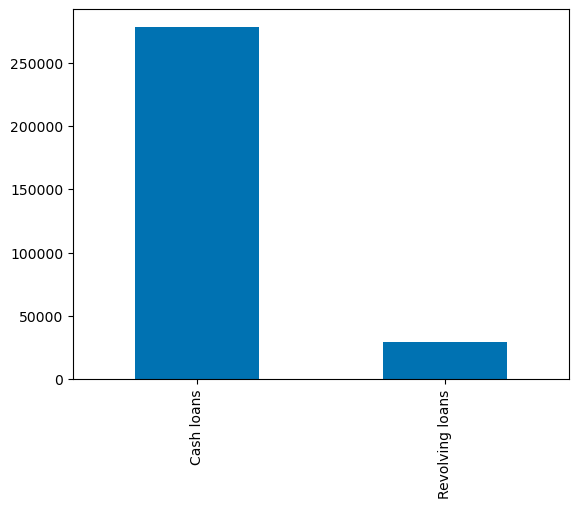

******************** CODE_GENDER ********************



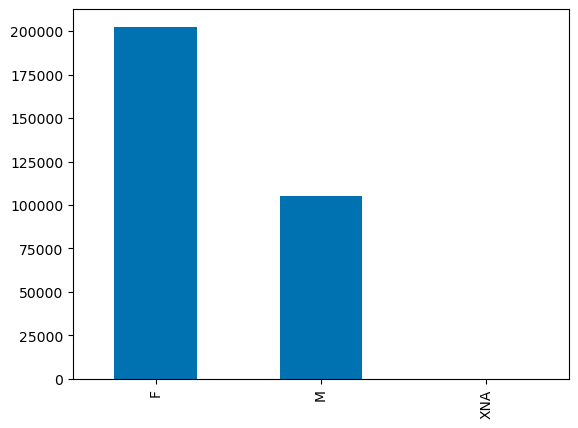

******************** FLAG_OWN_CAR ********************



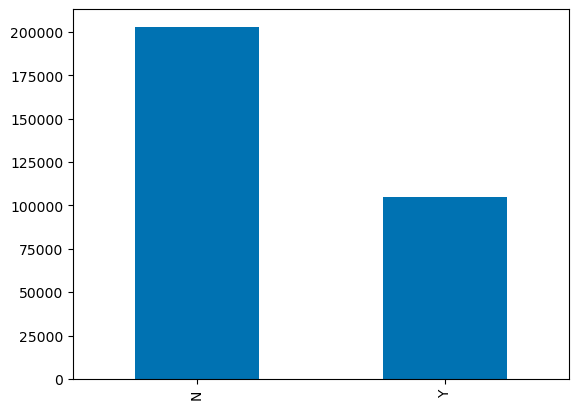

******************** FLAG_OWN_REALTY ********************



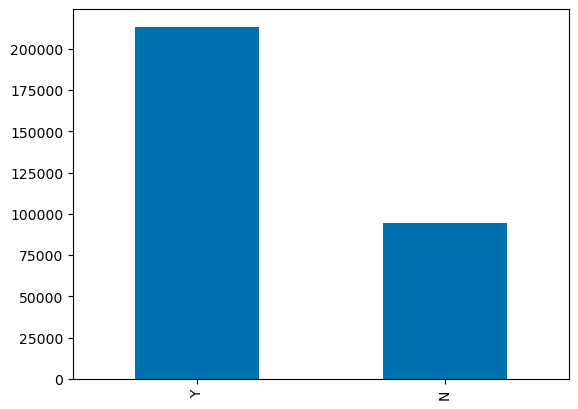

******************** NAME_TYPE_SUITE ********************



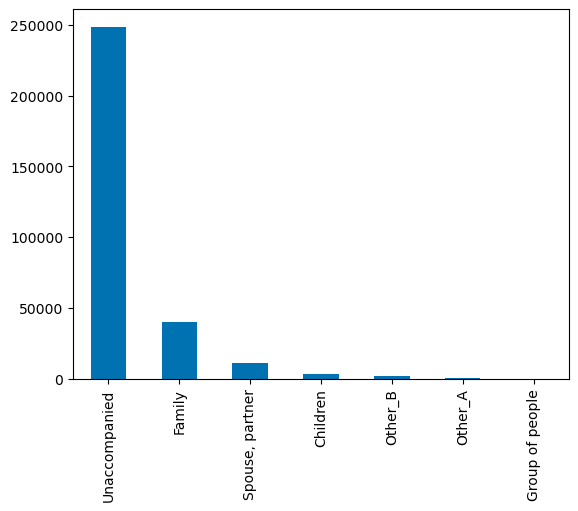

******************** NAME_INCOME_TYPE ********************



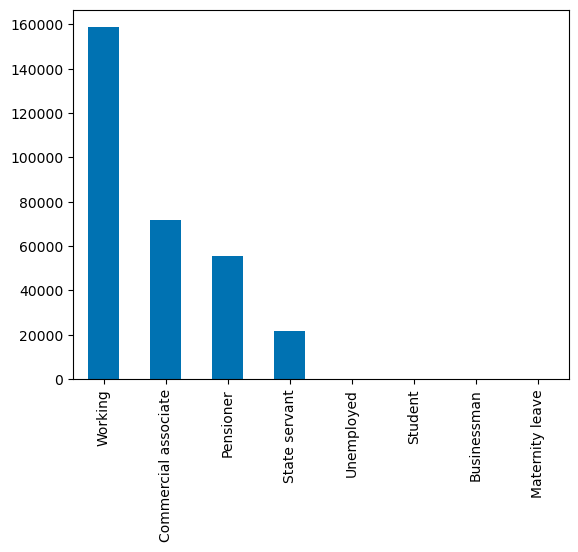

******************** NAME_EDUCATION_TYPE ********************



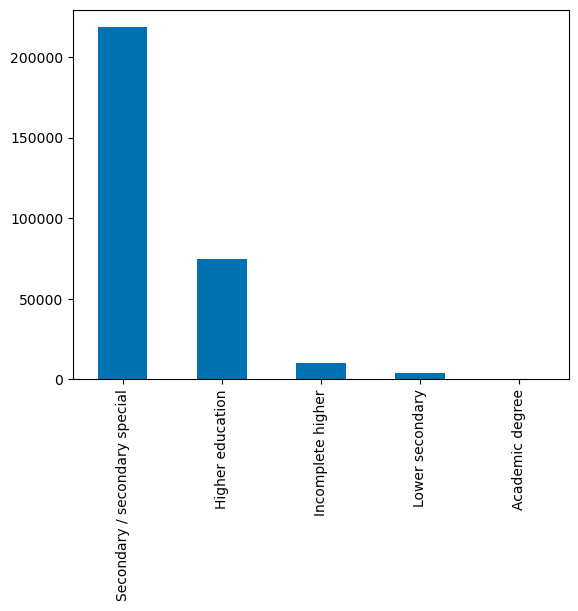

******************** NAME_FAMILY_STATUS ********************



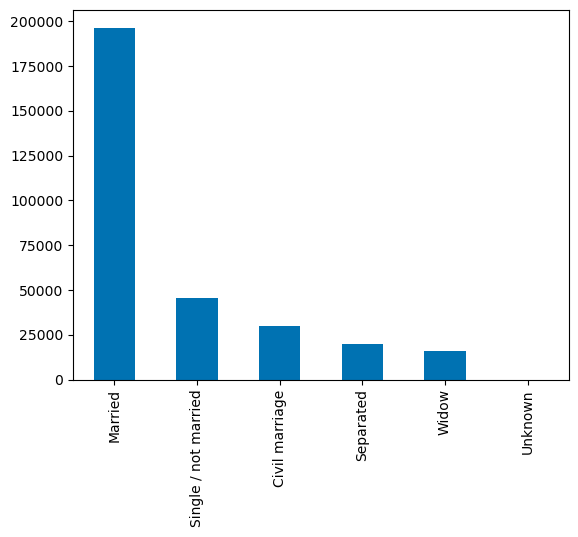

******************** NAME_HOUSING_TYPE ********************



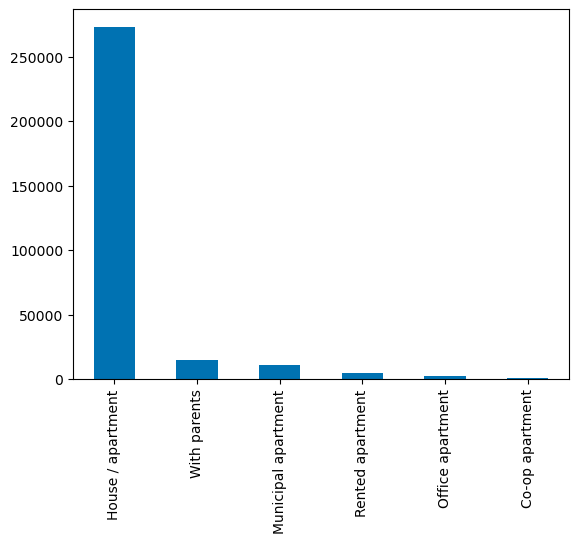

******************** OCCUPATION_TYPE ********************



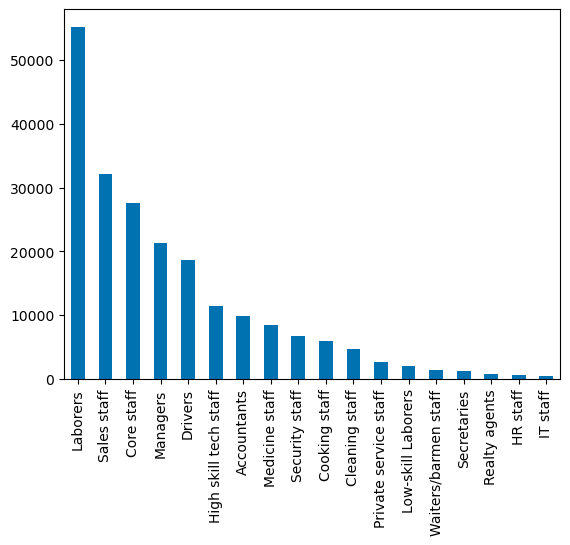

******************** WEEKDAY_APPR_PROCESS_START ********************



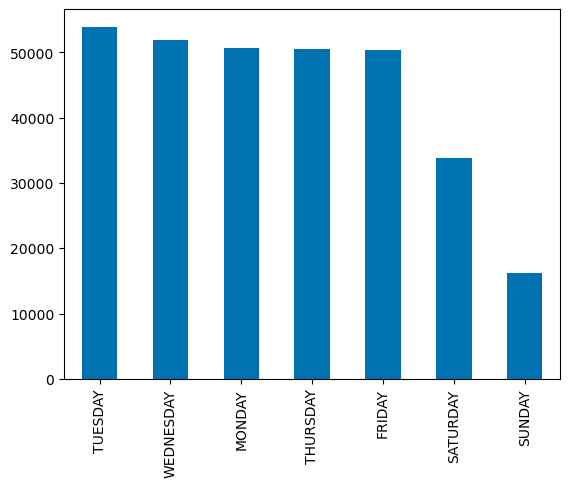

******************** ORGANIZATION_TYPE ********************



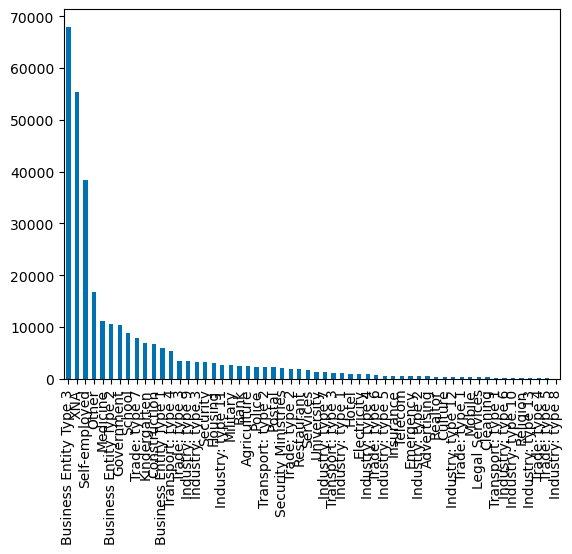

In [80]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical_train, col_names_cat[i])

melihat jumlah variabel nilai pada kolom "ORGANIZATION_TYPE"

In [81]:
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6'] 


Mengganti nilai null menggunakan mode

In [82]:
print("In train:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_train, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_test, col_names_cat[i])

In train:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in WEEKDAY_APPR_PROCESS_START raplaced with TUESDAY
NaN in ORGANIZATION_TYPE raplaced with Business Entity Type 3


****************************************

In test:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in N

In [83]:
pd.DataFrame(categorical_train.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [84]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


## 2. Numerical Field Manage Outlier (Only numeric_train nad whitout 'TARGET')

membuat variabel nama nama kolom "numeric_train" kecuali "TARGET"

In [85]:
numeric_train_oulier = numeric_train.drop(["TARGET"], axis = 1) 
numeric_train_col = numeric_train_oulier.columns

In [86]:
print(numeric_train_col)
print(len(numeric_train_col))

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLA

In [87]:
Q1 = numeric_train.quantile(0.25)
Q3 = numeric_train.quantile(0.75)
IQR = Q3 - Q1

Mendeteksi Outlier

In [88]:
print("In train:\n")
for i in range(len(numeric_train_col)):
    print("{}: {}".format(numeric_train_col[i],(outlier_detect(numeric_train,numeric_train_col[i]).shape[0])))

In train:

SK_ID_CURR: 0
CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_BIRTH: 0
DAYS_EMPLOYED: 72217
DAYS_REGISTRATION: 659
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 574
FLAG_PHONE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 80527
REGION_RATING_CLIENT_W_CITY: 78027
HOUR_APPR_PROCESS_START: 2257
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
EXT_SOURCE_2: 0
EXT_SOURCE_3: 4313
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 35166
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 25769
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_2: 13
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 25024
FLAG_

Mengambil kolom yang memiliki outlier

In [89]:
outlier = []
for i in range(len(numeric_train_col)):
    if outlier_detect(numeric_train[numeric_train_col],numeric_train_col[i]).shape[0] !=0:
        outlier.append(numeric_train_col[i])

Melihat jumlah kolom outlier

In [90]:
print(len(outlier))

54


Cek Upper Outlier Sebelum

In [91]:
print("In train:\n")
for i in range(len(numeric_train_col)):
    print("{}: {}".format(numeric_train_col[i],(upper_outlier(numeric_train,numeric_train_col[i]).shape[0])))

In train:

SK_ID_CURR: 0
CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_BIRTH: 0
DAYS_EMPLOYED: 55374
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 48330
REGION_RATING_CLIENT_W_CITY: 43860
HOUR_APPR_PROCESS_START: 596
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 35166
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 25769
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 13
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 25024
FLAG_DOCUMENT_9: 11

Mengatasi Upper Outlier

In [92]:
for i in range(len(numeric_train_col)):
    replace_upper(numeric_train, numeric_train_col[i])

Cek Upper Outlier Sesudah

In [93]:
print("In train:\n")
for i in range(len(numeric_train_col)):
    print("{}: {}".format(numeric_train_col[i],(upper_outlier(numeric_train,numeric_train_col[i]).shape[0])))

In train:

SK_ID_CURR: 0
CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 

Cek Lower Outlier Sebelum

In [94]:
print("In train:\n")
for i in range(len(numeric_train_col)):
    print("{}: {}".format(numeric_train_col[i],(lower_outlier(numeric_train,numeric_train_col[i]).shape[0])))

In train:

SK_ID_CURR: 0
CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 16843
DAYS_REGISTRATION: 659
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 574
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 32197
REGION_RATING_CLIENT_W_CITY: 34167
HOUR_APPR_PROCESS_START: 1661
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 4313
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUM

Mengatasi lower Outlier

In [95]:
for i in range(len(numeric_train_col)):
    replace_lower(numeric_train, numeric_train_col[i])

Cek Lower Outlier sesudah

In [96]:
print("In train:\n")
for i in range(len(numeric_train_col)):
    print("{}: {}".format(numeric_train_col[i],(lower_outlier(numeric_train,numeric_train_col[i]).shape[0])))

In train:

SK_ID_CURR: 0
CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 

In [97]:
numeric_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 61 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   CNT_CHILDREN                 307511 non-null  float64
 3   AMT_INCOME_TOTAL             307511 non-null  float64
 4   AMT_CREDIT                   307511 non-null  float64
 5   AMT_ANNUITY                  307511 non-null  float64
 6   AMT_GOODS_PRICE              307511 non-null  float64
 7   REGION_POPULATION_RELATIVE   307511 non-null  float64
 8   DAYS_BIRTH                   307511 non-null  int64  
 9   DAYS_EMPLOYED                307511 non-null  float64
 10  DAYS_REGISTRATION            307511 non-null  float64
 11  DAYS_ID_PUBLISH              307511 non-null  int64  
 12  FLAG_MOBIL                   307511 non-null  int64  
 13 

## 3. Label Encoder

kolom "ORGANIZATION_TYPE" karena memiliki terlalu banyak nilai yaitu 58 maka di drop

In [98]:
categorical_train.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

Melakukan Label Encoder

In [99]:
le = LabelEncoder() 
categorical_train = categorical_train.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START
0,0,1,0,1,6,7,4,3,1,8,6
1,0,0,0,0,1,4,1,1,1,3,1
2,1,1,1,1,6,7,4,3,1,8,1
3,0,0,0,1,6,7,4,0,1,8,6
4,0,1,0,1,6,7,4,3,1,3,4


In [100]:
print("In train: ",categorical_train.shape)
print("In test: ",categorical_test.shape)

In train:  (307511, 11)
In test:  (48744, 11)


## 4. Menggabungkan kolom kategorikal dengan numeric

In [101]:
col_names_cat = categorical_train.columns
col_names_numeric_train = numeric_train.columns
col_names_numeric_test = numeric_test.columns

In [102]:
print(col_names_cat.shape)
print(col_names_numeric_train.shape)
print(col_names_numeric_test.shape)

(11,)
(61,)
(60,)


Melakukan Menggabungkan kolom kategorikal dengan numeric

In [103]:
train_new[col_names_cat] = categorical_train[col_names_cat]
train_new[col_names_numeric_train] = numeric_train[col_names_numeric_train]

# ----------------------------------------------------
test_new[col_names_numeric_test] = numeric_test[col_names_numeric_test]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [104]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [105]:
train_new.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0.0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,0.262949,0.139376,2.0,0.0,2.0,0.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,3,2.0,2,2,1,11,0,0,0,0,0,0,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225.0,-4260.0,-2531,1,1,0,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0.0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,0,0,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  int32  
 3   CODE_GENDER                  307511 non-null  int32  
 4   FLAG_OWN_CAR                 307511 non-null  int32  
 5   FLAG_OWN_REALTY              307511 non-null  int32  
 6   CNT_CHILDREN                 307511 non-null  float64
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307511 non-null  float64
 10  AMT_GOODS_PRICE              307511 non-null  float64
 11  NAME_TYPE_SUITE              307511 non-null  int32  
 12  NAME_INCOME_TYPE             307511 non-null  int32  
 13 

## 5. Split Train Test

In [107]:
train_new.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0.0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,0.262949,0.139376,2.0,0.0,2.0,0.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,3,2.0,2,2,1,11,0,0,0,0,0,0,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225.0,-4260.0,-2531,1,1,0,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0.0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,0,0,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,0,1,0,1,0.0,99000.0,490495.5,27517.5,454500.0,5,4,4,1,1,0.035792,-16941,-1588.0,-4970.0,-477,1,1,0,1,1,0,8,2.0,2,2,6,16,0,0,0,0,0,0,0.354225,0.621226,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
6,100009,0,0,0,1,1,1.0,171000.0,1560726.0,41301.0,1341000.0,6,1,1,1,1,0.035792,-13778,-3130.0,-1213.0,-619,1,1,0,1,1,0,0,3.0,2,2,3,16,0,0,0,0,0,0,0.724000,0.492060,1.0,0.0,1.0,0.0,-1562.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7,100010,0,0,1,1,1,0.0,337500.0,1530000.0,42075.0,1341000.0,6,4,1,1,1,0.003122,-18850,-449.0,-4597.0,-2379,1,1,0,1,0,0,10,2.0,2,2,1,16,0,0,0,0,0,0,0.714279,0.540654,2.0,0.0,2.0,0.0,-1070.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,0,0,0,1,0.0,112500.0,1019610.0,33826.5,913500.0,0,3,4,1,1,0.018634,-20099,3417.5,-7427.0,-3514,1,1,0,1,0,0,8,2.0,2,2,6,14,0,0,0,0,0,0,0.205747,0.751724,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,1,1,0,1,0.0,135000.0,405000.0,20250.0,405000.0,6,7,4,3,1,0.019689,-14469,-2019.0,-14437.0,-3992,1,1,0,1,0,0,8,1.0,2,2,4,8,0,0,0,0,0,0,0.746644,0.535276,2.0,0.0,2.0,0.0,-1673.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [108]:
train_new.shape

(307511, 72)

In [109]:
X = train_new.drop(["SK_ID_CURR", "TARGET"], axis = 1) 
Y = train_new.TARGET
X_validasi = test_new.drop(["SK_ID_CURR"], axis = 1)

Membagi data menjadi train dan test menjadi data set "train" dengan perbandingan 70:30

In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 200)
print("X Training shape", X_train.shape)
print("X Testing shape", X_test.shape)
print("Y Training shape", y_train.shape)
print("Y Testing shape", y_test.shape)

X Training shape (215257, 70)
X Testing shape (92254, 70)
Y Training shape (215257,)
Y Testing shape (92254,)


In [111]:
col_names = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

final_numeric_feature_new = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

numeric = X_train[col_names]

numeric.head(10)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
226316,0.0,135000.0,225000.0,15034.5,225000.0,0.009549,-9209,-705.0,-1104.0,-470,1,1,0,1,1,0,2.0,2,2,9,0,0,0,0,0,0,0.616591,0.535276,2.0,0.0,2.0,0.0,-1369.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
41700,0.0,180000.0,1129500.0,58612.5,1129500.0,0.026392,-16698,-3732.0,-8307.0,-240,1,1,0,1,1,0,2.0,2,2,12,0,0,0,0,0,0,0.636638,0.684828,2.0,0.0,2.0,0.0,-1223.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
80304,2.5,157500.0,508495.5,27715.5,454500.0,0.007330,-11411,-1096.0,-809.0,-3937,1,1,0,1,0,0,4.5,2,2,13,0,0,0,0,0,0,0.526012,0.577969,2.0,0.0,2.0,0.0,-981.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
67995,1.0,135000.0,90000.0,4374.0,90000.0,0.022625,-10442,-404.0,-3840.0,-1472,1,1,0,1,0,0,3.0,2,2,14,0,0,0,0,0,0,0.755373,0.672243,4.0,0.0,4.0,0.0,-456.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
284728,0.0,157500.0,326664.0,16677.0,234000.0,0.030755,-12141,-409.0,-5389.0,-2075,1,1,0,1,0,0,1.0,2,2,14,0,0,0,0,0,0,0.591091,0.535276,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
303615,0.0,38250.0,284400.0,10345.5,225000.0,0.024610,-22784,3417.5,-7691.0,-4868,1,1,0,1,1,0,2.0,2,2,11,0,0,0,0,0,0,0.521102,0.780144,3.0,0.0,3.0,0.0,-1652.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
22063,0.0,90000.0,229500.0,11038.5,229500.0,0.015221,-20470,3417.5,-6920.0,-3820,1,1,0,1,1,0,1.0,2,2,13,0,0,0,0,0,0,0.767096,0.643026,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
83244,0.0,337500.0,1442596.5,38182.5,1129500.0,0.003818,-17220,-663.0,-350.0,-782,1,1,0,1,0,0,1.0,2,2,7,0,0,0,0,0,0,0.649989,0.155689,0.0,0.0,0.0,0.0,-12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100285,2.0,247500.0,640080.0,24259.5,450000.0,0.003813,-11462,-1828.0,-3858.0,-3790,1,1,0,1,0,0,4.0,2,2,12,0,0,0,0,0,0,0.692497,0.604113,1.0,0.0,1.0,0.0,-369.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,6.0
154836,0.0,256500.0,135000.0,6696.0,135000.0,0.031329,-12155,-114.0,-4985.0,-2770,1,1,0,1,0,0,1.0,2,2,16,0,0,0,0,0,0,0.673218,0.535276,0.0,0.0,0.0,0.0,-718.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [112]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(X_train,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 0
FLAG_DOCUMEN

In [113]:
outlier = []
for i in range(len(final_numeric_feature_new)):
    if outlier_detect(X_train[final_numeric_feature_new],final_numeric_feature_new[i]).shape[0] !=0:
        outlier.append(final_numeric_feature_new[i])

In [114]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(X_train,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 0
FLAG_DOCUMEN

In [115]:
for i in range(len(col_names)):
    replace_upper(X_train, col_names[i])   

In [116]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(X_train,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 0
FLAG_DOCUMEN

In [117]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(X_train,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 0
FLAG_DOCUMEN

In [118]:
for i in range(len(col_names)):
    replace_lower(X_train, col_names[i])
    
# #--------------------------------------------------
'''for i in range(len(col_names)):
    replace_lower(numeric_test, col_names[i])'''

'for i in range(len(col_names)):\n    replace_lower(numeric_test, col_names[i])'

In [119]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(X_train,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
'''print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))'''

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 0
FLAG_DOCUMEN

'print("In test:\n")\nfor i in range(len(col_names)):\n    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))'

In [120]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215257 entries, 226316 to 1818
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           215257 non-null  int32  
 1   CODE_GENDER                  215257 non-null  int32  
 2   FLAG_OWN_CAR                 215257 non-null  int32  
 3   FLAG_OWN_REALTY              215257 non-null  int32  
 4   CNT_CHILDREN                 215257 non-null  float64
 5   AMT_INCOME_TOTAL             215257 non-null  float64
 6   AMT_CREDIT                   215257 non-null  float64
 7   AMT_ANNUITY                  215257 non-null  float64
 8   AMT_GOODS_PRICE              215257 non-null  float64
 9   NAME_TYPE_SUITE              215257 non-null  int32  
 10  NAME_INCOME_TYPE             215257 non-null  int32  
 11  NAME_EDUCATION_TYPE          215257 non-null  int32  
 12  NAME_FAMILY_STATUS           215257 non-null  int32  
 

## 6. Normalization

Melakukan Nomalisasi data

In [121]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_col = X_train.columns

X_train[X_train_col] = scaler.fit_transform(X_train[X_train_col])
X_test[X_train_col] = scaler.fit_transform(X_test[X_train_col])

In [122]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
226316,0.0,0.0,0.0,1.0,0.0,0.350649,0.114531,0.223321,0.141869,1.000000,1.000000,1.00,0.2,0.2,0.164288,0.903044,0.582912,0.929609,0.934695,0.0,0.0,0.0,0.0,1.0,0.0,0.823529,0.285714,0.0,0.0,0.833333,0.3125,0.0,0.0,0.0,0.0,0.0,0.0,0.721159,0.554848,0.4,0.0,0.4,0.0,0.610415,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667
41700,0.0,0.0,1.0,1.0,0.0,0.494949,0.690050,0.948551,0.837370,1.000000,0.142857,1.00,0.2,0.2,0.463142,0.480891,0.276659,0.470344,0.966653,0.0,0.0,0.0,0.0,1.0,0.0,0.470588,0.285714,0.0,0.0,0.666667,0.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.744606,0.740443,0.4,0.0,0.4,0.0,0.651964,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
80304,0.0,0.5,0.0,1.0,1.0,0.422799,0.294915,0.434359,0.318339,0.833333,1.000000,0.25,0.2,0.2,0.124915,0.778918,0.543353,0.948418,0.452967,0.0,0.0,0.0,0.0,0.0,0.0,0.470588,1.000000,0.0,0.0,0.166667,0.5625,0.0,0.0,0.0,0.0,0.0,0.0,0.615219,0.607830,0.4,0.0,0.4,0.0,0.720831,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
67995,0.0,0.0,0.0,1.0,0.4,0.350649,0.028633,0.045907,0.038062,1.000000,1.000000,0.25,0.2,0.2,0.396302,0.833540,0.613365,0.755161,0.795470,0.0,0.0,0.0,0.0,0.0,0.0,0.823529,0.571429,0.0,0.0,0.000000,0.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.883478,0.724825,0.8,0.0,0.8,0.0,0.870233,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
284728,0.0,0.5,0.0,1.0,0.0,0.422799,0.179218,0.250655,0.148789,1.000000,1.000000,1.00,0.6,0.8,0.540557,0.737768,0.612859,0.656396,0.711685,0.0,0.0,0.0,0.0,0.0,0.0,0.235294,0.000000,0.0,0.0,0.833333,0.6250,0.0,0.0,0.0,0.0,0.0,0.0,0.691334,0.554848,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667


## 7. Handling class-imbalance

In [123]:
# Oversampling
ROS = RandomOverSampler(sampling_strategy='minority', random_state=1)
X_train_ROS, y_train_ROS = ROS.fit_resample(X_train, y_train)
np.bincount(y_train_ROS)

array([197903, 197903], dtype=int64)

# STAGE 3 - Modeling

## Model

### Logistic Regression

In [125]:
logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train_ROS, y_train_ROS) # fit model regression dari data train
scores_logreg_test = cross_validation(X_test, y_test, logreg)
print(scores_logreg_test)

Score: 0.735775
None


### Logistic Regression Classifier HyperParameters

In [126]:
logreg_oversampling = LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_oversampling.fit(X_train_ROS, y_train_ROS)
scores_logreg_oversampling_test = cross_validation(X_test, y_test, logreg_oversampling)
print(scores_logreg_oversampling_test)

Score: 0.525955
None


### Light GBM

In [127]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_ROS, y_train_ROS)
scores_logreg_test = cross_validation(X_test, y_test, lgbm)
print(scores_logreg_test)

Score: 0.740487
None


### LightGBM Classifier HyperParameters

In [128]:
lgb_tune = LGBMClassifier(**{'reg_lambda': 0.1, 
                        'reg_alpha': 0.2, 
                        'num_leaves': 70, 
                        'n_estimators': 250, 
                        'min_child_samples': 800, 
                        'learning_rate': 0.05,
                        'max_bin': 500,
                        'objective': 'binary',
                        'n_jobs': -1,
                        'class_weight':'balanced',
                        'random_state':100})

lgb_tune.fit(X_train_ROS, y_train_ROS)
lgb_tune_test = cross_validation(X_test, y_test, lgb_tune)
print(lgb_tune_test)

Score: 0.742355
None


## Feature Value

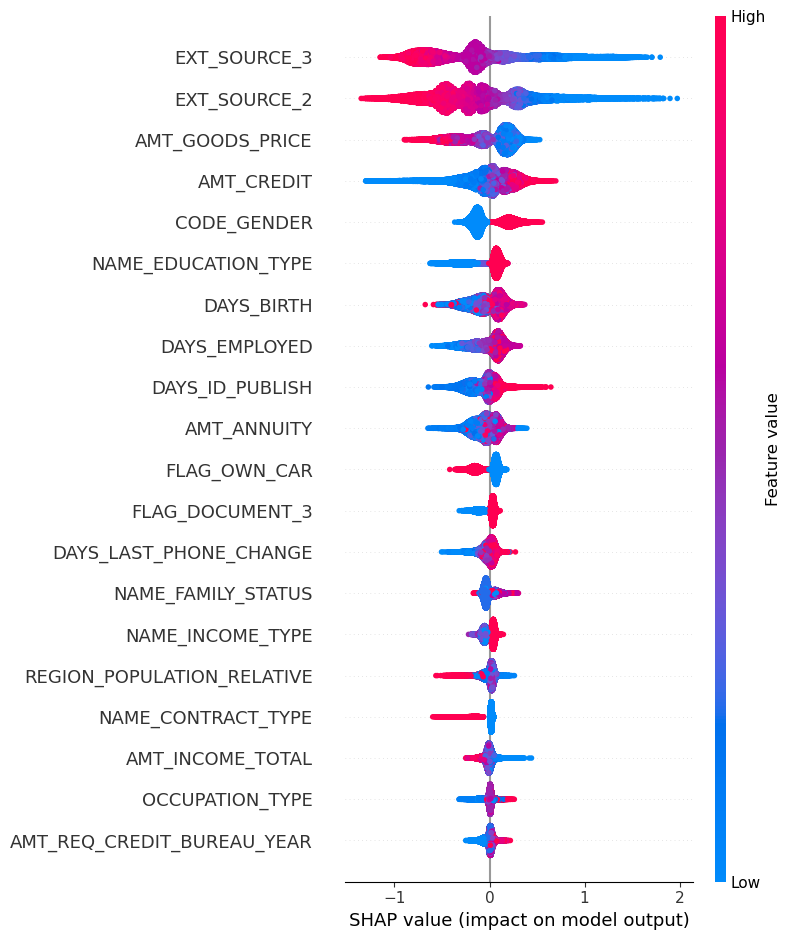

<Figure size 640x480 with 0 Axes>

In [166]:
import shap
explainer = shap.TreeExplainer(lgb_tune)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

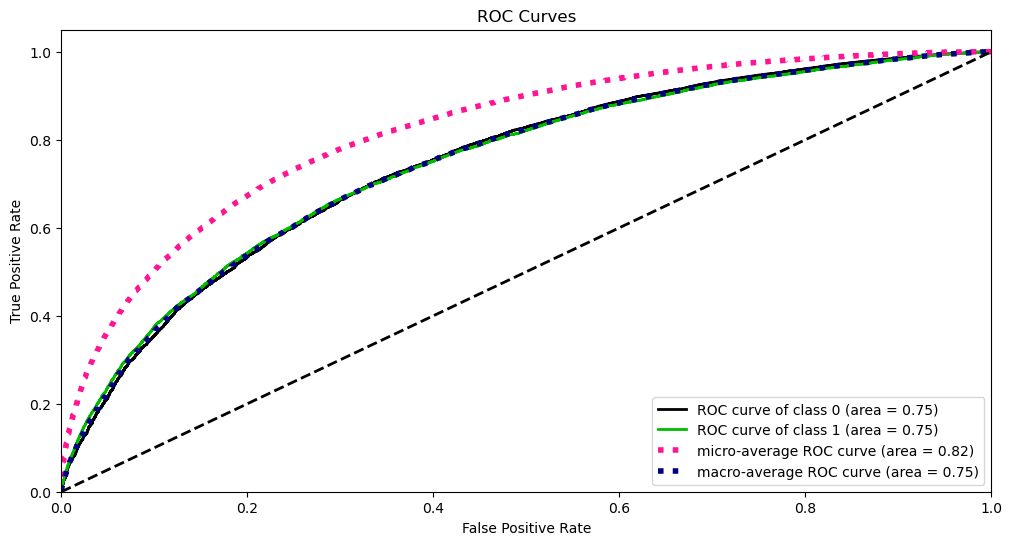

In [130]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(y_test, lgb_tune.predict_proba(X_test), figsize=(12,6))
plt.show()

## Result

In [131]:
LGB_tune_pred = lgb_tune.predict(X_validasi)
hasil = pd.DataFrame()
hasil['SK_ID_CURR'] = test_new['SK_ID_CURR']
hasil['TARGET'] = LGB_tune_pred
hasil.to_csv("lgb_baseline.csv", index=False)
print(hasil['TARGET'].value_counts())

0    46844
1     1900
Name: TARGET, dtype: int64


In [141]:
test_new["TARGET"] = hasil['TARGET']
test_new.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   48744 non-null  int64  
 1   NAME_CONTRACT_TYPE           48744 non-null  int32  
 2   CODE_GENDER                  48744 non-null  int32  
 3   FLAG_OWN_CAR                 48744 non-null  int32  
 4   FLAG_OWN_REALTY              48744 non-null  int32  
 5   CNT_CHILDREN                 48744 non-null  int64  
 6   AMT_INCOME_TOTAL             48744 non-null  float64
 7   AMT_CREDIT                   48744 non-null  float64
 8   AMT_ANNUITY                  48744 non-null  float64
 9   AMT_GOODS_PRICE              48744 non-null  float64
 10  NAME_TYPE_SUITE              48744 non-null  int32  
 11  NAME_INCOME_TYPE             48744 non-null  int32  
 12  NAME_EDUCATION_TYPE          48744 non-null  int32  
 13  NAME_FAMILY_STAT

In [139]:
test_new["TARGET"].value_counts()

0    46844
1     1900
Name: TARGET, dtype: int64

In [149]:
test_new.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
46769,441809,0,0,1,0,0,157500.0,248760.0,25488.0,225000.0,6,6,1,0,1,0.022625,-16058,-3410,-5119.0,-3992,1,1,1,1,1,0,17,2.0,2,2,6,0,0,0,0,0,0,0,0.420238,0.372334,0.0,0.0,0.0,0.0,-2501.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
8273,160626,0,0,1,0,0,157500.0,291384.0,28818.0,270000.0,6,6,4,1,1,0.010006,-12055,-2878,-1266.0,-3552,1,1,0,1,1,0,8,2.0,2,1,0,11,0,0,0,0,0,0,0.650472,0.363945,7.0,0.0,7.0,0.0,-470.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,0
15910,214657,0,0,0,1,0,202500.0,493497.0,48942.0,454500.0,6,3,4,3,1,0.018029,-19502,-3302,-3581.0,-2827,1,1,0,1,0,0,8,1.0,3,3,5,8,0,0,0,0,0,0,0.429203,0.670652,0.0,0.0,0.0,0.0,-1656.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0
47174,444795,0,0,0,1,0,144000.0,331920.0,15966.0,225000.0,6,3,4,1,1,0.020246,-16557,-153,-323.0,-113,1,1,1,1,0,0,14,2.0,3,3,6,14,0,1,1,0,1,1,0.581996,0.586740,0.0,0.0,0.0,0.0,-769.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
47978,450558,0,0,1,1,0,148500.0,360000.0,15264.0,360000.0,1,2,4,1,1,0.018850,-22851,365243,-8120.0,-4270,1,0,0,1,0,0,8,2.0,2,2,4,9,0,0,0,0,0,0,0.416003,0.448962,2.0,0.0,2.0,0.0,-1476.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0
25510,285701,0,0,0,1,0,112500.0,67500.0,7218.0,67500.0,6,3,0,3,1,0.005144,-9936,-816,-7921.0,-2607,1,1,1,1,1,0,3,1.0,2,2,0,14,0,0,0,0,0,0,0.576902,0.519097,0.0,0.0,0.0,0.0,-594.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0
14803,206640,0,0,0,1,0,202500.0,433057.5,22239.0,324000.0,6,6,4,0,1,0.010006,-12618,-2691,-2811.0,-5040,1,1,0,1,0,0,8,2.0,2,1,1,14,0,0,0,0,0,0,0.605344,0.511892,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0
3758,126738,0,0,0,1,0,135000.0,509400.0,28575.0,450000.0,6,2,1,1,1,0.007330,-23636,365243,-2035.0,-4248,1,0,0,1,0,0,8,2.0,2,2,6,14,0,0,0,0,0,0,0.325037,0.519097,2.0,0.0,2.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0
26186,290672,0,0,0,0,0,112500.0,399559.5,36774.0,342000.0,6,6,4,1,5,0.020713,-11712,-2383,-5285.0,-2834,1,1,0,1,0,1,11,2.0,3,2,5,5,0,0,0,0,0,0,0.347615,0.519097,1.0,1.0,1.0,1.0,-1834.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0,0
43203,414484,0,0,0,0,0,54000.0,485190.0,26451.0,405000.0,6,2,3,3,1,0.006629,-20201,365243,-5466.0,-1735,1,0,0,1,1,0,8,1.0,2,2,1,8,0,0,0,0,0,0,0.054445,0.519097,2.0,0.0,2.0,0.0,-616.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0


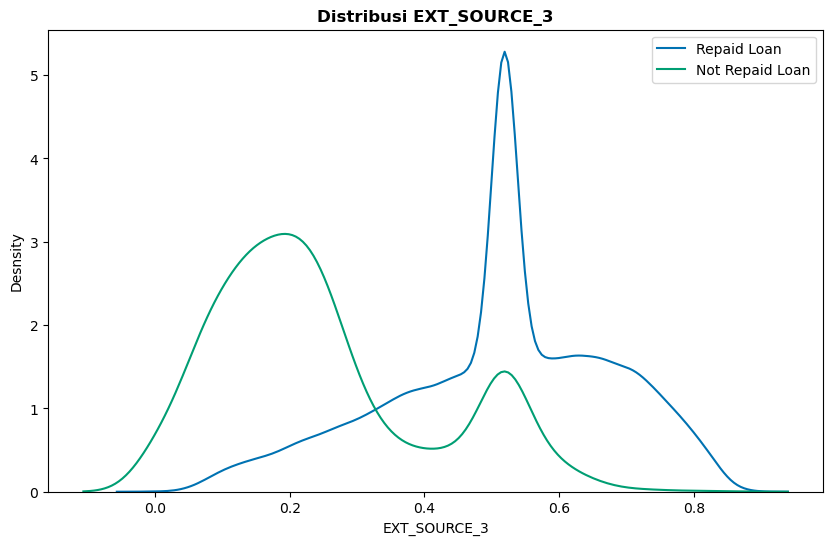

In [161]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(test_new.loc[test_new['TARGET'] == 0, 'EXT_SOURCE_3'], label = 'Repaid Loan')
sns.kdeplot(test_new.loc[test_new['TARGET'] == 1, 'EXT_SOURCE_3'], label = 'Not Repaid Loan')
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('Desnsity')
plt.legend()
plt.title('Distribusi EXT_SOURCE_3', fontweight='bold')
plt.savefig("Distribusi EXT_SOURCE_3.png")
plt.show()

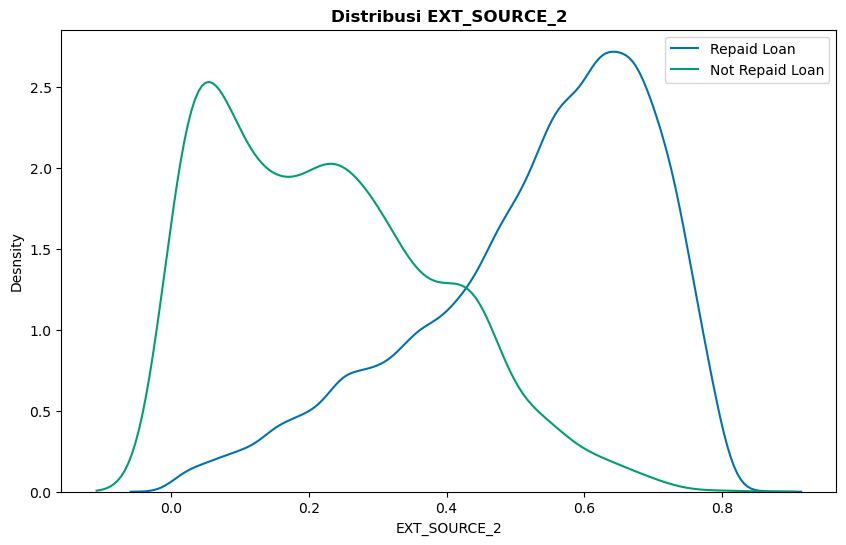

In [162]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(test_new.loc[test_new['TARGET'] == 0, 'EXT_SOURCE_2'], label = 'Repaid Loan')
sns.kdeplot(test_new.loc[test_new['TARGET'] == 1, 'EXT_SOURCE_2'], label = 'Not Repaid Loan')
plt.xlabel('EXT_SOURCE_2')
plt.ylabel('Desnsity')
plt.legend()
plt.title('Distribusi EXT_SOURCE_2', fontweight='bold')
plt.savefig("Distribusi EXT_SOURCE_2.png")
plt.show()

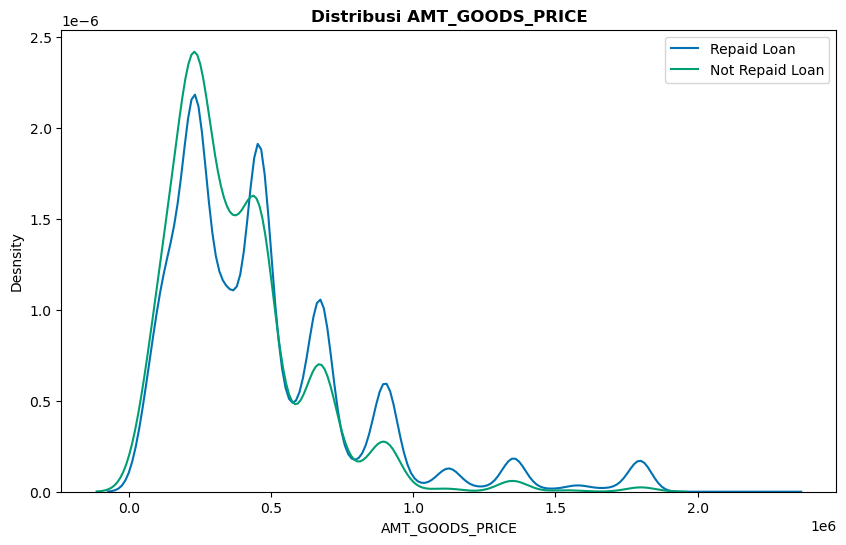

In [163]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(test_new.loc[test_new['TARGET'] == 0, 'AMT_GOODS_PRICE'], label = 'Repaid Loan')
sns.kdeplot(test_new.loc[test_new['TARGET'] == 1, 'AMT_GOODS_PRICE'], label = 'Not Repaid Loan')
plt.xlabel('AMT_GOODS_PRICE')
plt.ylabel('Desnsity')
plt.legend()
plt.title('Distribusi AMT_GOODS_PRICE', fontweight='bold')
plt.savefig("Distribusi AMT_GOODS_PRICE.png")
plt.show()

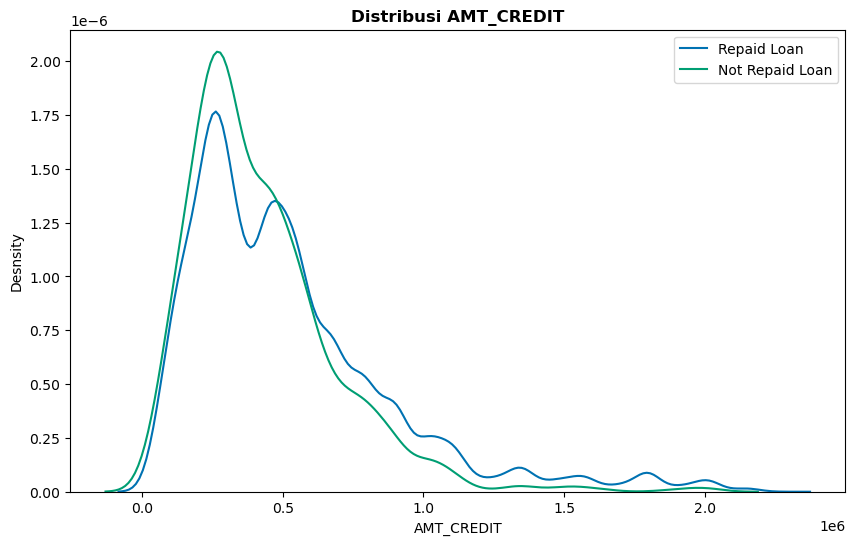

In [164]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(test_new.loc[test_new['TARGET'] == 0, 'AMT_CREDIT'], label = 'Repaid Loan')
sns.kdeplot(test_new.loc[test_new['TARGET'] == 1, 'AMT_CREDIT'], label = 'Not Repaid Loan')
plt.xlabel('AMT_CREDIT')
plt.ylabel('Desnsity')
plt.legend()
plt.title('Distribusi AMT_CREDIT', fontweight='bold')
plt.savefig("Distribusi AMT_CREDIT.png")
plt.show()

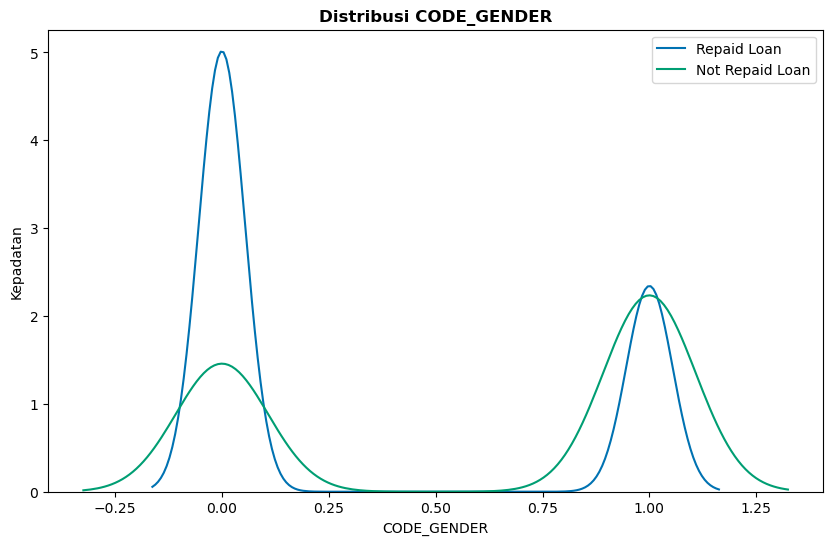

In [165]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(False)
sns.kdeplot(test_new.loc[test_new['TARGET'] == 0, 'CODE_GENDER'], label = 'Repaid Loan')
sns.kdeplot(test_new.loc[test_new['TARGET'] == 1, 'CODE_GENDER'], label = 'Not Repaid Loan')
plt.xlabel('CODE_GENDER')
plt.ylabel('Kepadatan')
plt.legend()
plt.title('Distribusi CODE_GENDER', fontweight='bold')
plt.savefig("Distribusi CODE_GENDER.png")
plt.show()